In [118]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import datetime as dt
import requests, copy, json
from pprint import pprint
from bs4 import BeautifulSoup
from bball_ref_scraper import BBRefScraper
from bball_ref_id_generator import id_generator

### Create Initial DataFrame from scraping http://www.prosportstransactions.com/

In [2]:
df_json = pd.read_json("../data/pst_nba_injuries_2020_2021.txt")
df = df_json.copy()
df.head(5)

,Date,Team,Healed,Injured,Notes
0,2020-03-11,76ers,Joel Embiid,,activated from IL
1,2020-03-11,Bucks,Eric Bledsoe,,activated from IL
2,2020-03-11,Bucks,George Hill,,activated from IL
3,2020-03-11,Bulls,,Chandler Hutchison,surgery on right shoulder (out for season)
4,2020-03-11,Heat,,Jimmy Butler,placed on IL with left big toe injury


### Reformat the DataFrame

In [3]:

df['Player'] = df['Healed'] + df['Injured']
df['Status'] = np.where(df['Healed'] == '', 'Injured', 'Healed')
df = df[['Date', 'Team', 'Player', 'Status', 'Notes']]
df.head(10)

,Date,Team,Player,Status,Notes
0,2020-03-11,76ers,Joel Embiid,Healed,activated from IL
1,2020-03-11,Bucks,Eric Bledsoe,Healed,activated from IL
2,2020-03-11,Bucks,George Hill,Healed,activated from IL
3,2020-03-11,Bulls,Chandler Hutchison,Injured,surgery on right shoulder (out for season)
4,2020-03-11,Heat,Jimmy Butler,Injured,placed on IL with left big toe injury
5,2020-03-11,Heat,Jae Crowder,Healed,returned to lineup
6,2020-03-11,Heat,Tyler Herro,Healed,activated from IL
7,2020-03-11,Hornets,Terry Rozier,Injured,placed on IL with illness
8,2020-03-11,Jazz,Emmanuel Mudiay,Injured,illness (DTD)
9,2020-03-11,Jazz,Rudy Gobert,Injured,COVID-19 coronavirus (out indefinitely)


### Extract players out for COVID or "Health and Safety Protocols"

In [4]:
df_cv19 = df[np.logical_or(df['Notes'].str.contains('COVID'), df['Notes'].str.contains('protocol'))]
df_cv19

,Date,Team,Player,Status,Notes
9,2020-03-11,Jazz,Rudy Gobert,Injured,COVID-19 coronavirus (out indefinitely)
19,2020-03-12,Jazz,Donovan Mitchell,Injured,COVID-19 coronavirus (DTD)
21,2020-03-14,Pistons,Christian Wood,Injured,COVID-19 coronavirus (DTD)
22,2020-03-17,Nets,Kevin Durant,Injured,NBA health and safety protocols (DTD)
24,2020-03-19,Celtics,Marcus Smart,Injured,COVID-19 coronavirus (out indefinitely)
...,...,...,...,...,...
2846,2021-05-09,Pistons,Hamidou Diallo,Injured,placed on IL with NBA health and safety protocols
2957,2021-05-14,Thunder,Josh Hall,Injured,placed on IL with NBA health and safety protoc...
2969,2021-05-15,Heat,Omer Yurtseven,Injured,placed on IL with NBA health and safety protocols
3031,2021-05-16,Spurs,DaQuan Jeffries,Injured,placed on IL with NBA health and safety protoc...


240 instances of players being held out due to COVID protocols since 03/11/2020 (The day Rudy Gobert tested positive and the league shut down)

### Just COVID data for 2020-2021 NBA Season

In [5]:
df_cv19_2021 = df_cv19[df_cv19['Date'] >= '12-01-2020']
df_cv19_2021

,Date,Team,Player,Status,Notes
415,2020-12-22,Blazers,Nassir Little,Injured,COVID-19 (DTD)
423,2020-12-22,Hawks,Rajon Rondo,Injured,placed on IL with NBA health and safety protocols
468,2020-12-23,Rockets,Kenyon Martin Jr. / K.J. Martin,Injured,placed on IL with NBA health and safety protocols
472,2020-12-25,Bucks,Mamadi Diakite,Injured,placed on IL with NBA health and safety protoc...
475,2020-12-25,Rockets,Ben McLemore,Injured,COVID-19 protocols
...,...,...,...,...,...
2846,2021-05-09,Pistons,Hamidou Diallo,Injured,placed on IL with NBA health and safety protocols
2957,2021-05-14,Thunder,Josh Hall,Injured,placed on IL with NBA health and safety protoc...
2969,2021-05-15,Heat,Omer Yurtseven,Injured,placed on IL with NBA health and safety protocols
3031,2021-05-16,Spurs,DaQuan Jeffries,Injured,placed on IL with NBA health and safety protoc...


230 instances of players being held out due to COVID protocols during 2020-2021 NBA season

### Unique Players

In [6]:
players = df_cv19_2021['Player'].unique()
len(players)

182

182 Unique Players were held out due to COVID protocols during 2020-2021 NBA season

### Generate basketball-reference.com IDs

In [7]:
bbref_id_list = []
for player in players:
    bbref_id = id_generator(player)
    if isinstance(bbref_id, tuple):
        print('Something messed up')
    else:
        bbref_id_list.append([player, bbref_id])

/Users/mbun/Code/dsi_galvanize/capstones/capstone_1/NBA-COVID-19-Investigation/code/bball_ref_id_generator.py:29: GuessedAtParserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 29 of the file /Users/mbun/Code/dsi_galvanize/capstones/capstone_1/NBA-COVID-19-Investigation/code/bball_ref_id_generator.py. To get rid of this warning, pass the additional argument 'features="lxml"' to the BeautifulSoup constructor.

  soup = BeautifulSoup(r.content, 'html')
/Users/mbun/Code/dsi_galvanize/capstones/capstone_1/NBA-COVID-19-Investigation/code/bball_ref_id_generator.py:44: GuessedAtParserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a 

In [8]:
df_bbref_id = pd.DataFrame(bbref_id_list, columns=['Player', 'BBRef_ID'])
df_bbref_id

,Player,BBRef_ID
0,Nassir Little,littlna01
1,Rajon Rondo,rondora01
2,Kenyon Martin Jr. / K.J. Martin,martike04
3,Mamadi Diakite,diakima01
4,Ben McLemore,mclembe01
...,...,...
177,Luca Vildoza,vildolu01
178,Hamidou Diallo,diallha01
179,Omer Yurtseven,yurtsom01
180,DaQuan Jeffries,jeffrda01


### Merging BBRef IDs with DataFrame

In [9]:
df_main = pd.merge(left=df_cv19_2021, right=df_bbref_id, how='left', left_on=df_cv19_2021.Player, right_on=df_bbref_id.Player).drop("key_0", axis=1).drop('Player_y', axis=1)
df_main.rename(columns={'Player_x':'Player'}, inplace=True)
df_main

,Date,Team,Player,Status,Notes,BBRef_ID
0,2020-12-22,Blazers,Nassir Little,Injured,COVID-19 (DTD),littlna01
1,2020-12-22,Hawks,Rajon Rondo,Injured,placed on IL with NBA health and safety protocols,rondora01
2,2020-12-23,Rockets,Kenyon Martin Jr. / K.J. Martin,Injured,placed on IL with NBA health and safety protocols,martike04
3,2020-12-25,Bucks,Mamadi Diakite,Injured,placed on IL with NBA health and safety protoc...,diakima01
4,2020-12-25,Rockets,Ben McLemore,Injured,COVID-19 protocols,mclembe01
...,...,...,...,...,...,...
225,2021-05-09,Pistons,Hamidou Diallo,Injured,placed on IL with NBA health and safety protocols,diallha01
226,2021-05-14,Thunder,Josh Hall,Injured,placed on IL with NBA health and safety protoc...,halljo01
227,2021-05-15,Heat,Omer Yurtseven,Injured,placed on IL with NBA health and safety protocols,yurtsom01
228,2021-05-16,Spurs,DaQuan Jeffries,Injured,placed on IL with NBA health and safety protoc...,jeffrda01


### Scrape 

In [10]:
!pwd 


/Users/mbun/Code/dsi_galvanize/capstones/capstone_1/NBA-COVID-19-Investigation/code


```
for player, bbr_id in bbref_id_list:
    print(player)
    game_log = BBRefScraper(bbr_id).game_log_scraper(2021)
    filename = f'../data/game_logs/{bbr_id}_gamelog_2020_2021.txt'
    with open(filename, 'w') as outfile:
        json.dump(game_log, outfile)
```

In [192]:
random_bbrid = 'duranke01'
list(df_main[df_main['BBRef_ID'] == random_bbrid]['Date'])
test_df['GmSc'].max()

37.3

(0.0, 48.0)

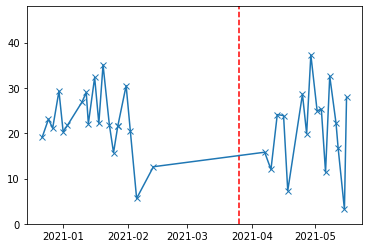

In [187]:
test_df = pd.read_json(f'../data/game_logs/{random_bbrid}_gamelog_2020_2021.txt').dropna()
# test_df[test_df['Date'] < '2021-03-26'].dropna().describe()
test_df['MP'] = pd.to_datetime(test_df['MP'], format='%M:%S')
# test_df['MP'] = pd.to_timedelta(test_df['MP'])
# test_df['MP'].apply(pd.Timedelta)
# plt.plot(test_df['Date'], test_df['MP'].astype(float))
test_df['MP'] = test_df['MP'].dt.minute + test_df['MP'].dt.second/60
plt.plot(test_df['Date'], test_df['GmSc'], marker='x')
plt.vlines(dt.date(2021, 3, 26), 0, 48, color='red', ls='--')
plt.ylim([0,48])

In [14]:
gby_player = df_cv19_2021.groupby('Player')

In [70]:
counts = gby_player.count()
# list(counts[counts['Date'] == 1].index)


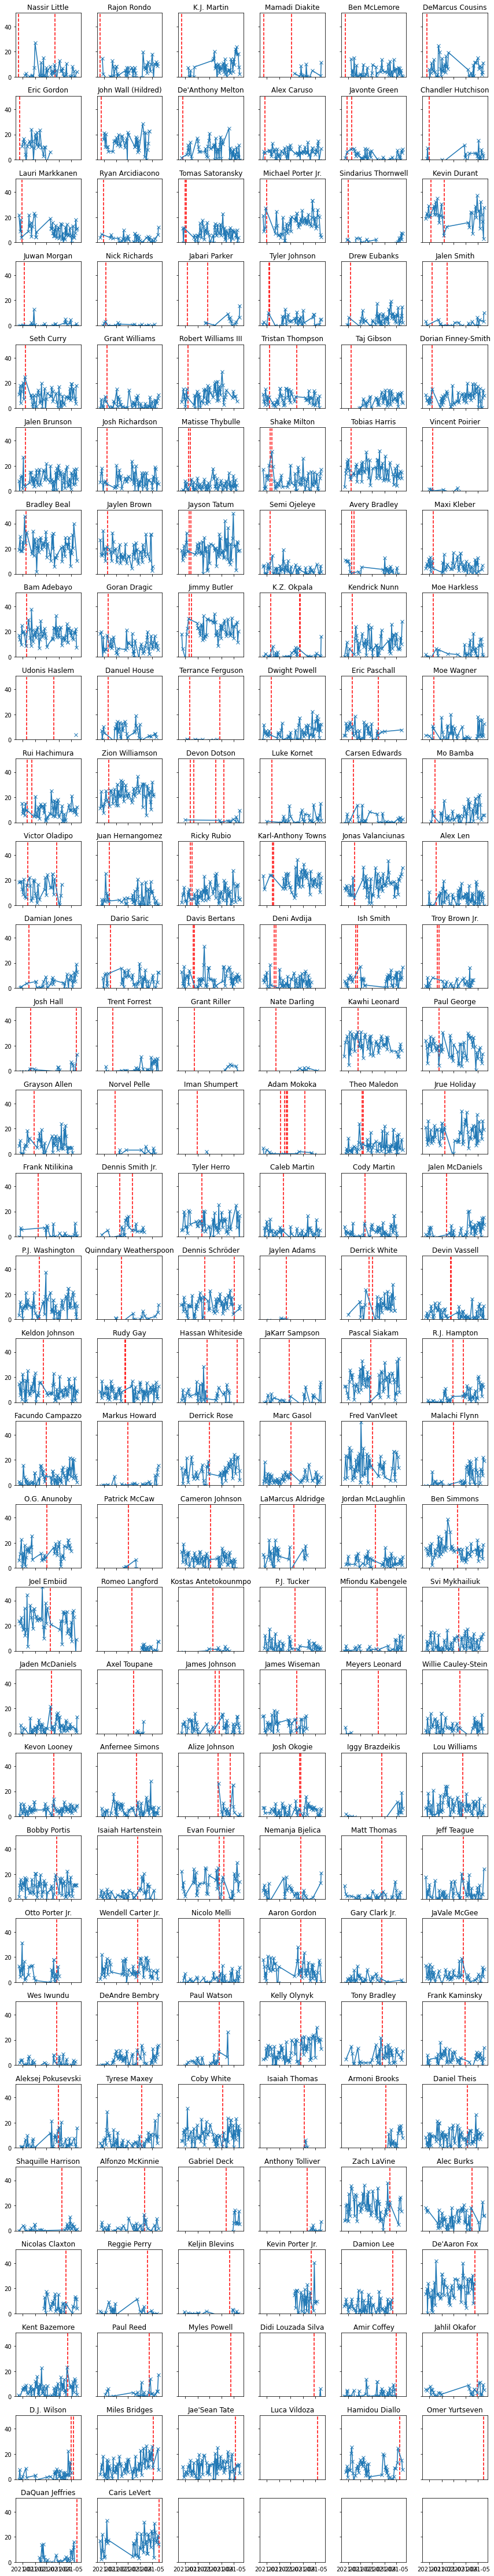

In [193]:
fig, axs = plt.subplots(31,6, figsize=(12, 62), sharex=True, sharey=True)
max_y = 0
for ax, [player, bbrid] in zip(axs.flatten(), bbref_id_list):
    if '/' in player:
        ax.set_title(player.split(' / ')[1])
    else:
        ax.set_title(player)
    gmlog_df = pd.read_json(f'../data/game_logs/{bbrid}_gamelog_2020_2021.txt').dropna()
    cv19dates = list(df_main[df_main['BBRef_ID'] == bbrid]['Date'])
    ax.plot(gmlog_df['Date'], gmlog_df['GmSc'], marker='x')
    player_max_y = gmlog_df['GmSc'].max()
    if player_max_y > max_y:
        max_y = player_max_y
    for cv19date in cv19dates:
        ax.vlines(cv19date, 0, 50, color='red', ls='--')
plt.ylim([0, max_y])
fig.tight_layout()

In [162]:
182/6

30.333333333333332

In [181]:
tn = 'Kenyon Martin Jr. / K.J. Martin'
tn.split(' / ')[1]

'K.J. Martin'